# WeatherPy
----

### Analysis

* The temperatures appear evenly distributed between 40 and 85 degrees F.     Interesting was there were very few cities in southern hemisphere less than 40 degrees.   There were many in the northern hemisphere less than 40 degrees.    This may be due to fewer cities in the southern hemisphere, or some of our cities not found may have been in this area.
*   There is no strong relationship between latitude and humidity.    Again in this example, there are fewer cities in the southern hemisphere.    
* For all latitudes, the highest concentration of cloudiness was 0%.   It was also interesting to see the high number of cities with cloud coverage above 80%    
* Wind speed is consistent across all latitudes.

---


In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
import requests
import time
import json

# Import API key
from api_keys import myKey

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

In [2]:
#Adding to ignore the warning for appending the values in the next step.  
#Error is:  SettingWithCopyWarning:   A value is trying to be set on a copy of a slice from a DataFrame
pd.options.mode.chained_assignment = None  # default='warn'   

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
countries = []

# Create a set of random lat and lng combinations.   Increased size to 1750 because I was not alwyas getting 500 cities from the weather APIs.
lats = np.random.uniform(low=-90.000, high=90.000, size=1750)  
lngs = np.random.uniform(low=-180.000, high=180.000, size=1750)
lat_lngs = zip(lats, lngs)
#uniform is to have the numbers evenly distributed
#size is how many random numbers will be generated.
#we are saying, generate 1500 random evenly distributed numbers between -90 and 90.

# Identify nearest city for each lat, lng combination
for each in lat_lngs:
    city = citipy.nearest_city(each[0], each[1]).city_name 
    country = citipy.nearest_city(each[0], each[1]).country_code 
    
    # If the city is unique, then add it to the cities list
    if city not in cities:
        cities.append(city)
        countries.append(country)

# Print the city count to confirm at least 600 records.   (The next step with weather api, on average, does not find 20%.)
len(cities)

#There must be at least 500 on the next part of finding the weather.  If not, then must come back to this step and increase size.

686

In [4]:
len(countries)

686

In [5]:
#??  how do I see the ln_lngs list?
print(lat_lngs)

In [6]:
print(lngs)

[  49.22056951  165.84690355  -86.62960385 ...   27.22351549   70.7280051
 -110.94961073]


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [7]:
#first, perform a check on a single city.

In [8]:
url = "http://api.openweathermap.org/data/2.5/weather?"
city = "alofi"
units = "imperial"

# Build query URL
query_url = url + "appid=" + myKey + "&q=" + city + "&units=imperial"
#note:   adding imperial units will return the temperature in farenheight and the wind speed in miles per hour
print(query_url)

http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&q=alofi&units=imperial


In [9]:
# Get weather data
weather_response = requests.get(query_url)
weather_json = weather_response.json()


In [10]:
print(json.dumps(weather_json, indent=4, sort_keys=True))

{
    "base": "stations",
    "clouds": {
        "all": 8
    },
    "cod": 200,
    "coord": {
        "lat": -19.06,
        "lon": -169.92
    },
    "dt": 1554674400,
    "id": 4036284,
    "main": {
        "humidity": 70,
        "pressure": 1016,
        "temp": 86,
        "temp_max": 86,
        "temp_min": 86
    },
    "name": "Alofi",
    "sys": {
        "country": "NU",
        "id": 7306,
        "message": 0.0043,
        "sunrise": 1554658057,
        "sunset": 1554700532,
        "type": 1
    },
    "weather": [
        {
            "description": "clear sky",
            "icon": "02d",
            "id": 800,
            "main": "Clear"
        }
    ],
    "wind": {
        "deg": 60,
        "speed": 9.17
    }
}


In [11]:
#Success!   Able to retrieve a single city.
#now retrieve each individual piece of data needed for the loop

In [12]:
print(weather_json["name"])

Alofi


In [13]:
print(weather_json["coord"]["lat"])

-19.06


In [14]:
print(weather_json["main"]["temp"])

86


In [15]:
print(weather_json["main"]["humidity"])

70


In [16]:
print(weather_json["clouds"]["all"])

8


In [17]:
print(weather_json["wind"]["speed"])

9.17


### need a dataframe containing city and country to begin
NOTE:   the Weather API will take only a city; however, if multiples are found, API responds with a list of results that match a searching word. 
<BR>
Therefore, I will begin with a list of cities and countries which can also be passed to the 
    <BR>q city name and country code divided by comma, use ISO 3166 country codes
        
<BR> https://openweathermap.org/current

In [18]:
#Begin with the city and country list which was created in the begining.

cityCountry = pd.DataFrame(list(zip(cities, countries)),
              columns=['city','country'])

cityCountry.head()

,city,country
0,eyl,so
1,pevek,ru
2,nicoya,cr
3,daru,pg
4,rio gallegos,ar


In [19]:
#confirm there are at least 500 countries
len(cityCountry)

686

In [20]:
# create a data frome with the values needed for the API calls

cityCountry2 = cityCountry
cityCountry2["location"] = (cityCountry2["city"] + ", " + cityCountry2["country"])
cityCountry2["newCity"] = ""
cityCountry2["newCountry"] = ""
cityCountry2["lat"] = ""
cityCountry2["long"] = ""
cityCountry2["tempF"] = ""
cityCountry2["humidity"] = ""
cityCountry2["cloud"] = ""
cityCountry2["windMPH"] = ""
cityCountry2["maxTemp"] = ""
cityCountry2["date"] = ""
cityCountry2.head()

,city,country,location,newCity,newCountry,lat,long,tempF,humidity,cloud,windMPH,maxTemp,date
0,eyl,so,"eyl, so",,,,,,,,,,
1,pevek,ru,"pevek, ru",,,,,,,,,,
2,nicoya,cr,"nicoya, cr",,,,,,,,,,
3,daru,pg,"daru, pg",,,,,,,,,,
4,rio gallegos,ar,"rio gallegos, ar",,,,,,,,,,


## Retrieve Data from the API
Practice on 10 cities before attemping to get data for 500+ cities

In [21]:
#create a new df with only 10 records
cityCountrySample = cityCountry2.head(10)
cityCountrySample.head(20)

,city,country,location,newCity,newCountry,lat,long,tempF,humidity,cloud,windMPH,maxTemp,date
0,eyl,so,"eyl, so",,,,,,,,,,
1,pevek,ru,"pevek, ru",,,,,,,,,,
2,nicoya,cr,"nicoya, cr",,,,,,,,,,
3,daru,pg,"daru, pg",,,,,,,,,,
4,rio gallegos,ar,"rio gallegos, ar",,,,,,,,,,
5,longyearbyen,sj,"longyearbyen, sj",,,,,,,,,,
6,kahului,us,"kahului, us",,,,,,,,,,
7,ilulissat,gl,"ilulissat, gl",,,,,,,,,,
8,noumea,nc,"noumea, nc",,,,,,,,,,
9,busselton,au,"busselton, au",,,,,,,,,,


In [22]:
cityCountrySample.dtypes

city          object
country       object
location      object
newCity       object
newCountry    object
lat           object
long          object
tempF         object
humidity      object
cloud         object
windMPH       object
maxTemp       object
date          object
dtype: object

In [23]:
#cast the timeStamp as a date type
cityCountrySample['date'] = pd.to_datetime(cityCountrySample['date'])

In [24]:
#ensure I can get a single response using parameters
parameters = {"appid": myKey,
             "units": "imperial",
             "q": "vaini, to"}
base_url = "http://api.openweathermap.org/data/2.5/weather?"

In [25]:
#get the API response
singleResponse = requests.get(base_url, params=parameters)

In [26]:
#confirm the URL
print(singleResponse.url)

http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=vaini%2C+to


In [27]:
#convert the response to JSON 
singleResponseJ = singleResponse.json()

In [28]:
#print the response to view the data
print(json.dumps(singleResponseJ, indent=4, sort_keys=True))

{
    "base": "stations",
    "clouds": {
        "all": 80
    },
    "cod": 200,
    "coord": {
        "lat": -21.2,
        "lon": -175.2
    },
    "dt": 1554676216,
    "id": 4032243,
    "main": {
        "grnd_level": 1013.38,
        "humidity": 97,
        "pressure": 1013.53,
        "sea_level": 1013.53,
        "temp": 81.39,
        "temp_max": 81.39,
        "temp_min": 81.39
    },
    "name": "Vaini",
    "rain": {
        "3h": 0.93
    },
    "sys": {
        "country": "TO",
        "message": 0.0044,
        "sunrise": 1554745810,
        "sunset": 1554788078
    },
    "weather": [
        {
            "description": "light rain",
            "icon": "10d",
            "id": 500,
            "main": "Rain"
        }
    ],
    "wind": {
        "deg": 33.5001,
        "speed": 10.98
    }
}


In [29]:
#success!  I can get a valid URL using parameters.  

###  Complete for 10 Records
Before applying to all records, complete the for loop for a small sample.

In [30]:
import datetime as dt
timeTest = pd.Series([dt.datetime.now()])
print(timeTest)

0   2019-04-07 18:30:15.932097
dtype: datetime64[ns]


In [31]:
# create a parameters dict that will be updated with new city each iteration
#per API, imperial units will obtain temperature in F and wind speed in mph
parameters = {"appid": myKey,
             "units": "imperial"}

print("---------------------------------------------") 
print("Beginning Data Retrieval")
print("---------------------------------------------") 
      
#begin by knowing the number of cities
print("Number of cities to obtain data: " + str(len(cityCountry))) 
print("---------------------------------------------")       

# Loop through the cityCountrySample and perform a search on each
for index, row in cityCountrySample.iterrows():
    base_url = "http://api.openweathermap.org/data/2.5/weather?"

    city = row['city']
    country = row['country']

    # update address key value
    parameters['q'] = f"{city},{country}"

    # make request
    cities_data = requests.get(base_url, params=parameters)
    
    #print the record number 
    print("Retrieving index # " + str(index) + " | " + row["city"] + ", " + row["country"])
    
    #confirm the URL
    print("  " + (cities_data.url))
        
    # convert to json
    citiesJ = cities_data.json()
    
    try:
        cityCountrySample.loc[index, "newCity"] = citiesJ["name"]
    except:
        print("     Missing city name... skipping this city.")   
    
    try:    
        cityCountrySample.loc[index, "newCountry"] = citiesJ["sys"]["country"]
    except: 
        dumbVariable = 1
 
    try:    
        cityCountrySample.loc[index, "lat"] = citiesJ["coord"]["lat"]
    except: 
        dumbVariable = 1
        
    try:    
        cityCountrySample.loc[index, "long"] = citiesJ["coord"]["lon"]
    except: 
        dumbVariable = 1
        
    try:    
        cityCountrySample.loc[index, "tempF"] = citiesJ["main"]["temp"]
    except: 
        dumbVariable = 1
        
    try:    
        cityCountrySample.loc[index, "humidity"] = citiesJ["main"]["humidity"]
    except: 
        dumbVariable = 1
        
    try:    
        cityCountrySample.loc[index, "cloud"] = citiesJ["clouds"]["all"]
    except: 
        dumbVariable = 1
     
    try:    
        cityCountrySample.loc[index, "windMPH"] = citiesJ["wind"]["speed"]
    except: 
        dumbVariable = 1
        
    try:    
        cityCountrySample.loc[index, "maxTemp"] = citiesJ["main"]["temp_max"]
    except: 
        dumbVariable = 1
    
    #add the timestamp when the record was added.   ??does not work for timestamp.   Works for today's date.
    try:
        #cityCountrySample.loc[index, "timeStamp"] = pd.Series([dt.datetime.now()])
        cityCountrySample.loc[index, "date"] = dt.date.today()
    except:
        dumbVariable = 1
    
    #the openweather API is free for up to 60 calls per minute.  Add a sleep timer to wait .75 seconds between calls.
    time.sleep(.75)

#At least 500 cities must be included for the next step of creating graphics.   Ensure there are at least 500 cities.   
#This is only a valid check for the full sample, not the sample of 10.
#however, the total will indicate the number of records with no newCity (in the sample of 10), which is valuable.

#obtain the number of records where a city was not found
noRecord = len(cityCountrySample[cityCountrySample['newCity'] == ""])
print("Records not found in the weather database: " + str(noRecord))

#subtract these from the number of records at the beginning
endRecords = (len(cityCountry)) - noRecord

initRecords = (len(cityCountry))

print("---------------------------------------------")
print("Beginning Records: " + str(initRecords))
print("Ending Records: " + str(endRecords))

if endRecords < 500:
    print("The data sample is less than 500, which is too small.  Please start from the beginning to obtain a new data sample.")
    print("---------------------------------------------")   
    #store the dataframe to a csv so the user can get details if needed.
    cityCountrySample.to_csv("output_data/weatherData_sample10small.csv", encoding='utf-8', index=False)
    print("All data collected is stored in output_data/weatherData_sample10small.csv")  

else: 
    print("There are more than 500 ending records!   Continue to the graphs.")
    cityCountrySample.to_csv("output_data/weatherData_sample10.csv", encoding='utf-8', index=False)
    print("All data collected is stored in output_data/weatherData_sample10.csv")

print("---------------------------------------------")   
print("Date Retrieval Complete")
print("---------------------------------------------")   


# Visualize to confirm new city and new country appear
cityCountrySample.head(10)


---------------------------------------------
Beginning Data Retrieval
---------------------------------------------
Number of cities to obtain data: 686
---------------------------------------------
Retrieving index # 0 | eyl, so
  http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=eyl%2Cso
Retrieving index # 1 | pevek, ru
  http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=pevek%2Cru
Retrieving index # 2 | nicoya, cr
  http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=nicoya%2Ccr
Retrieving index # 3 | daru, pg
  http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=daru%2Cpg
Retrieving index # 4 | rio gallegos, ar
  http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=rio+gallegos%2Car
Retrieving index # 5 | longyearbyen, sj
  htt

,city,country,location,newCity,newCountry,lat,long,tempF,humidity,cloud,windMPH,maxTemp,date
0,eyl,so,"eyl, so",Eyl,SO,7.98,49.82,74.91,100,12,5.17,74.91,2019-04-07
1,pevek,ru,"pevek, ru",Pevek,RU,69.7,170.27,5.52,99,12,5.06,5.52,2019-04-07
2,nicoya,cr,"nicoya, cr",Nicoya,CR,10.15,-85.45,93.2,46,20,8.05,93.2,2019-04-07
3,daru,pg,"daru, pg",Daru,PG,-9.07,143.21,83.1,100,44,4.72,83.1,2019-04-07
4,rio gallegos,ar,"rio gallegos, ar",Rio Gallegos,AR,-51.62,-69.22,50,61,40,4.7,50,2019-04-07
5,longyearbyen,sj,"longyearbyen, sj",Longyearbyen,SJ,78.22,15.64,5,92,20,8.05,5,2019-04-07
6,kahului,us,"kahului, us",Kahului,US,20.89,-156.47,78.76,51,20,10.29,82.4,2019-04-07
7,ilulissat,gl,"ilulissat, gl",Ilulissat,GL,69.22,-51.1,39.2,48,44,16.11,39.2,2019-04-07
8,noumea,nc,"noumea, nc",Noumea,NC,-22.28,166.46,75.2,69,0,5.82,75.2,2019-04-07
9,busselton,au,"busselton, au",Busselton,AU,-33.64,115.35,48.72,64,0,12.33,51.01,2019-04-07


In [32]:
#remove the rows with no newCity  These are the records which were not found 
cityCountrySample2 = cityCountrySample[cityCountrySample.newCity != ""].reset_index()
cityCountrySample2.head(10)

,index,city,country,location,newCity,newCountry,lat,long,tempF,humidity,cloud,windMPH,maxTemp,date
0,0,eyl,so,"eyl, so",Eyl,SO,7.98,49.82,74.91,100,12,5.17,74.91,2019-04-07
1,1,pevek,ru,"pevek, ru",Pevek,RU,69.7,170.27,5.52,99,12,5.06,5.52,2019-04-07
2,2,nicoya,cr,"nicoya, cr",Nicoya,CR,10.15,-85.45,93.2,46,20,8.05,93.2,2019-04-07
3,3,daru,pg,"daru, pg",Daru,PG,-9.07,143.21,83.1,100,44,4.72,83.1,2019-04-07
4,4,rio gallegos,ar,"rio gallegos, ar",Rio Gallegos,AR,-51.62,-69.22,50,61,40,4.7,50,2019-04-07
5,5,longyearbyen,sj,"longyearbyen, sj",Longyearbyen,SJ,78.22,15.64,5,92,20,8.05,5,2019-04-07
6,6,kahului,us,"kahului, us",Kahului,US,20.89,-156.47,78.76,51,20,10.29,82.4,2019-04-07
7,7,ilulissat,gl,"ilulissat, gl",Ilulissat,GL,69.22,-51.1,39.2,48,44,16.11,39.2,2019-04-07
8,8,noumea,nc,"noumea, nc",Noumea,NC,-22.28,166.46,75.2,69,0,5.82,75.2,2019-04-07
9,9,busselton,au,"busselton, au",Busselton,AU,-33.64,115.35,48.72,64,0,12.33,51.01,2019-04-07


## Retrieve data on all cities 
Since the practice run on 10 entries works well, complete the exercise on all records.

In [33]:
#create a new df to store the values from the API
apiData = cityCountry2
apiData.head(20)

,city,country,location,newCity,newCountry,lat,long,tempF,humidity,cloud,windMPH,maxTemp,date
0,eyl,so,"eyl, so",,,,,,,,,,
1,pevek,ru,"pevek, ru",,,,,,,,,,
2,nicoya,cr,"nicoya, cr",,,,,,,,,,
3,daru,pg,"daru, pg",,,,,,,,,,
4,rio gallegos,ar,"rio gallegos, ar",,,,,,,,,,
5,longyearbyen,sj,"longyearbyen, sj",,,,,,,,,,
6,kahului,us,"kahului, us",,,,,,,,,,
7,ilulissat,gl,"ilulissat, gl",,,,,,,,,,
8,noumea,nc,"noumea, nc",,,,,,,,,,
9,busselton,au,"busselton, au",,,,,,,,,,


In [34]:
# create a parameters dict that will be updated with new city each iteration
#per API, imperial units will obtain temperature in F and wind speed in mph
parameters = {"appid": myKey,
             "units": "imperial"}

print("---------------------------------------------") 
print("Beginning Data Retrieval")
print("---------------------------------------------") 
      
#begin by knowing the number of cities
print("Number of cities to obtain data: " + str(len(cityCountry))) 
print("---------------------------------------------")       

# Loop through the cityCountrySample and perform a search on each
for index, row in apiData.iterrows():
    base_url = "http://api.openweathermap.org/data/2.5/weather?"

    city = row['city']
    country = row['country']

    # update address key value
    parameters['q'] = f"{city},{country}"

    # make request
    cities_data = requests.get(base_url, params=parameters)
    
    #print the record number  ??? how do I print the index number?
    print("Retrieving index # " + str(index) + " | " + row["city"] + ", " + row["country"])
    
    #confirm the URL
    print("  " + (cities_data.url))
        
    # convert to json
    citiesJ = cities_data.json()
    
    try:
        apiData.loc[index, "newCity"] = citiesJ["name"]
    except:
        print("     Missing city name... skipping this city.")     
    
    try:    
        apiData.loc[index, "newCountry"] = citiesJ["sys"]["country"]
    except: 
        dumbVariable = 1
 
    try:    
        apiData.loc[index, "lat"] = citiesJ["coord"]["lat"]
    except: 
        dumbVariable = 1
        
    try:    
        apiData.loc[index, "long"] = citiesJ["coord"]["lon"]
    except: 
        dumbVariable = 1
        
    try:    
        apiData.loc[index, "tempF"] = citiesJ["main"]["temp"]
    except: 
        dumbVariable = 1
        
    try:    
        apiData.loc[index, "humidity"] = citiesJ["main"]["humidity"]
    except: 
        dumbVariable = 1
        
    try:    
        apiData.loc[index, "cloud"] = citiesJ["clouds"]["all"]
    except: 
        dumbVariable = 1
     
    try:    
        apiData.loc[index, "windMPH"] = citiesJ["wind"]["speed"]
    except: 
        dumbVariable = 1
        
    try:    
        apiData.loc[index, "maxTemp"] = citiesJ["main"]["temp_max"]
    except: 
        dumbVariable = 1
    
    try:
        #add the timestamp when the record was retrieved
        #apiData.loc[index, "timeStamp"] = pd.Series([dt.datetime.now()])
        apiData.loc[index, "date"] = dt.date.today()
    
    except:
        dumbVariable = 1
    
    #the openweather API is free for up to 60 calls per minute.  Add a sleep timer to wait .75 seconds between calls.
    time.sleep(.75)

#At least 500 cities must be included for the next step of creating graphics.   Ensure there are at least 500 cities.

#obtain the number of records where a city was not found
noRecord = len(apiData[apiData['newCity'] == ""])
print("Records not found in the weather database: " + str(noRecord))

#subtract these from the number of records at the beginning
endRecords = (len(cityCountry)) - noRecord

initRecords = (len(cityCountry))

print("---------------------------------------------")
print("Beginning # of Cities: " + str(initRecords))
print("Ending # of Cities: " + str(endRecords))
print("Cities not found in the weather database: " + str(noRecord))

if endRecords < 500:
    print("The data sample is less than 500, which is too small.  Please start from the beginning to obtain a new data sample.")
    print("---------------------------------------------")  
    
    #save the data to a csv in case the user needs to view the details
    apiData.to_csv("output_data/weatherData_smallSample.csv", encoding='utf-8', index=False)
    print("All data collected is stored in output_data/weatherData_SmallSample.csv")

else: 
    print("There are more than 500 ending records!   Continue to the graphs.")
    apiData.to_csv("output_data/weatherData.csv", encoding='utf-8', index=False)
    print("All data collected is stored in output_data/weatherData.csv")
    


print("---------------------------------------------")   
print("Date Retrieval Complete")
print("---------------------------------------------")   
    
# Visualize to confirm new city and new country appear
apiData.head(10)


---------------------------------------------
Beginning Data Retrieval
---------------------------------------------
Number of cities to obtain data: 686
---------------------------------------------
Retrieving index # 0 | eyl, so
  http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=eyl%2Cso
Retrieving index # 1 | pevek, ru
  http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=pevek%2Cru
Retrieving index # 2 | nicoya, cr
  http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=nicoya%2Ccr
Retrieving index # 3 | daru, pg
  http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=daru%2Cpg
Retrieving index # 4 | rio gallegos, ar
  http://api.openweathermap.org/data/2.5/weather?appid=8bea25d5e18b7c2fb2ee3ac12cec5dad&units=imperial&q=rio+gallegos%2Car
Retrieving index # 5 | longyearbyen, sj
  htt

,city,country,location,newCity,newCountry,lat,long,tempF,humidity,cloud,windMPH,maxTemp,date
0,eyl,so,"eyl, so",Eyl,SO,7.98,49.82,74.91,100,12,5.17,74.91,2019-04-07
1,pevek,ru,"pevek, ru",Pevek,RU,69.7,170.27,5.52,99,12,5.06,5.52,2019-04-07
2,nicoya,cr,"nicoya, cr",Nicoya,CR,10.15,-85.45,93.2,46,20,8.05,93.2,2019-04-07
3,daru,pg,"daru, pg",Daru,PG,-9.07,143.21,83.1,100,44,4.72,83.1,2019-04-07
4,rio gallegos,ar,"rio gallegos, ar",Rio Gallegos,AR,-51.62,-69.22,50,61,40,4.7,50,2019-04-07
5,longyearbyen,sj,"longyearbyen, sj",Longyearbyen,SJ,78.22,15.64,5,92,20,8.05,5,2019-04-07
6,kahului,us,"kahului, us",Kahului,US,20.89,-156.47,78.76,51,20,10.29,82.4,2019-04-07
7,ilulissat,gl,"ilulissat, gl",Ilulissat,GL,69.22,-51.1,39.2,48,44,16.11,39.2,2019-04-07
8,noumea,nc,"noumea, nc",Noumea,NC,-22.28,166.46,75.2,69,0,5.82,75.2,2019-04-07
9,busselton,au,"busselton, au",Busselton,AU,-33.64,115.35,48.72,64,0,12.33,51.01,2019-04-07


In [35]:
#remove the rows with no newCity  These are the records which were not found 
apiData2 = apiData[apiData.newCity != ""].reset_index()
apiData2.head(10)

,index,city,country,location,newCity,newCountry,lat,long,tempF,humidity,cloud,windMPH,maxTemp,date
0,0,eyl,so,"eyl, so",Eyl,SO,7.98,49.82,74.91,100,12,5.17,74.91,2019-04-07
1,1,pevek,ru,"pevek, ru",Pevek,RU,69.7,170.27,5.52,99,12,5.06,5.52,2019-04-07
2,2,nicoya,cr,"nicoya, cr",Nicoya,CR,10.15,-85.45,93.2,46,20,8.05,93.2,2019-04-07
3,3,daru,pg,"daru, pg",Daru,PG,-9.07,143.21,83.1,100,44,4.72,83.1,2019-04-07
4,4,rio gallegos,ar,"rio gallegos, ar",Rio Gallegos,AR,-51.62,-69.22,50,61,40,4.7,50,2019-04-07
5,5,longyearbyen,sj,"longyearbyen, sj",Longyearbyen,SJ,78.22,15.64,5,92,20,8.05,5,2019-04-07
6,6,kahului,us,"kahului, us",Kahului,US,20.89,-156.47,78.76,51,20,10.29,82.4,2019-04-07
7,7,ilulissat,gl,"ilulissat, gl",Ilulissat,GL,69.22,-51.1,39.2,48,44,16.11,39.2,2019-04-07
8,8,noumea,nc,"noumea, nc",Noumea,NC,-22.28,166.46,75.2,69,0,5.82,75.2,2019-04-07
9,9,busselton,au,"busselton, au",Busselton,AU,-33.64,115.35,48.72,64,0,12.33,51.01,2019-04-07


In [36]:
#confirm the number matches the end processing summary offered above
apiData2.count()

index         589
city          589
country       589
location      589
newCity       589
newCountry    589
lat           589
long          589
tempF         589
humidity      589
cloud         589
windMPH       589
maxTemp       589
date          589
dtype: int64

### Convert the datatypes for matplotlib

In [37]:
#copy the df.  This is not needed, but completing this step in case I need to refer back to apiData2
apiData3 = apiData2
apiData3.dtypes

index          int64
city          object
country       object
location      object
newCity       object
newCountry    object
lat           object
long          object
tempF         object
humidity      object
cloud         object
windMPH       object
maxTemp       object
date          object
dtype: object

In [38]:
apiData3.head()

,index,city,country,location,newCity,newCountry,lat,long,tempF,humidity,cloud,windMPH,maxTemp,date
0,0,eyl,so,"eyl, so",Eyl,SO,7.98,49.82,74.91,100,12,5.17,74.91,2019-04-07
1,1,pevek,ru,"pevek, ru",Pevek,RU,69.7,170.27,5.52,99,12,5.06,5.52,2019-04-07
2,2,nicoya,cr,"nicoya, cr",Nicoya,CR,10.15,-85.45,93.2,46,20,8.05,93.2,2019-04-07
3,3,daru,pg,"daru, pg",Daru,PG,-9.07,143.21,83.1,100,44,4.72,83.1,2019-04-07
4,4,rio gallegos,ar,"rio gallegos, ar",Rio Gallegos,AR,-51.62,-69.22,50,61,40,4.7,50,2019-04-07


In [39]:
#change the data types so numbers are floats, and also the datetime
apiData3.lat= apiData3.lat.astype(float)
apiData3.long= apiData3.long.astype(float)
apiData3.tempF= apiData3.tempF.astype(float)
apiData3.humidity= apiData3.humidity.astype(float)
apiData3.cloud= apiData3.cloud.astype(float)
apiData3.windMPH= apiData3.windMPH.astype(float)
apiData3.maxTemp= apiData3.maxTemp.astype(float)
apiData3['date'] = pd.to_datetime(apiData3['date'])
apiData3.dtypes

index                  int64
city                  object
country               object
location              object
newCity               object
newCountry            object
lat                  float64
long                 float64
tempF                float64
humidity             float64
cloud                float64
windMPH              float64
maxTemp              float64
date          datetime64[ns]
dtype: object

In [40]:
apiData3.head()

,index,city,country,location,newCity,newCountry,lat,long,tempF,humidity,cloud,windMPH,maxTemp,date
0,0,eyl,so,"eyl, so",Eyl,SO,7.98,49.82,74.91,100.0,12.0,5.17,74.91,2019-04-07
1,1,pevek,ru,"pevek, ru",Pevek,RU,69.70,170.27,5.52,99.0,12.0,5.06,5.52,2019-04-07
2,2,nicoya,cr,"nicoya, cr",Nicoya,CR,10.15,-85.45,93.20,46.0,20.0,8.05,93.20,2019-04-07
3,3,daru,pg,"daru, pg",Daru,PG,-9.07,143.21,83.10,100.0,44.0,4.72,83.10,2019-04-07
4,4,rio gallegos,ar,"rio gallegos, ar",Rio Gallegos,AR,-51.62,-69.22,50.00,61.0,40.0,4.70,50.00,2019-04-07


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

For all graphs, the latitude was changed to the y axis so the graphs are more logical to the end user.

#### Latitude vs. Temperature Plot

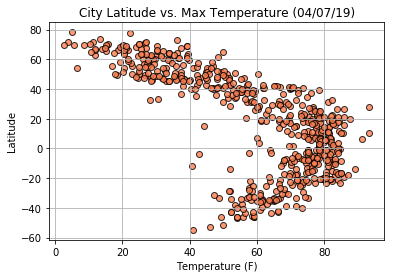

In [41]:
plt.scatter(apiData3["tempF"], 
            apiData3["lat"], 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Lorie")

# Incorporate the other graph properties
plt.title("City Latitude vs. Max Temperature (%s)" % time.strftime("%x"))
plt.ylabel("Latitude")
plt.xlabel("Temperature (F)")
plt.grid(True)

# Save the figure
plt.savefig("output_data/fig1_latitudeTemp.png", bbox_inches = "tight")

# Show plot
plt.show()
#For all graphs, the latitude was changed to the y axis so the graphs are more logical to the end user.
#Interesting that time after time, there are few cities in the southern hemisphere with temperatures less than 40 degrees.

#### Latitude vs. Humidity Plot

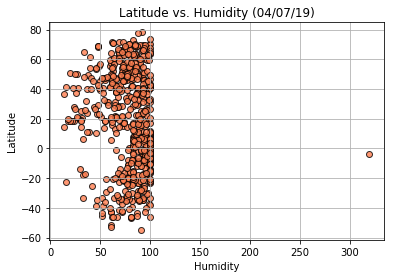

In [42]:
plt.scatter(apiData3["humidity"], 
            apiData3["lat"], 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Lorie")

# Incorporate the other graph properties
plt.title("Latitude vs. Humidity (%s)" % time.strftime("%x"))
plt.xlabel("Humidity")
plt.ylabel("Latitude")
plt.grid(True)

# Save the figure
plt.savefig("output_data/fig2_latitudeHumidity.png", bbox_inches = "tight")

# Show plot
plt.show()

#### Latitude vs. Cloudiness Plot

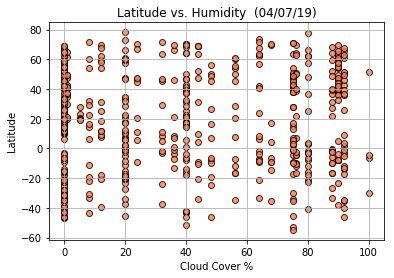

In [43]:
plt.scatter(apiData3["cloud"], 
            apiData3["lat"], 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Lorie")

# Incorporate the other graph properties
plt.title("Latitude vs. Humidity  (%s)" % time.strftime("%x"))
plt.ylabel("Latitude")
plt.xlabel("Cloud Cover %")
plt.grid(True)

# Save the figure
plt.savefig("output_data/fig3_latitudeCloudiness.png", bbox_inches = "tight")

# Show plot
plt.show()

#### Latitude vs. Wind Speed Plot

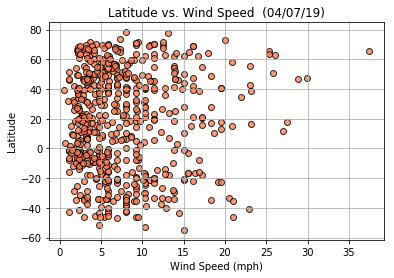

In [44]:
plt.scatter(apiData3["windMPH"], 
            apiData3["lat"], 
            c="coral", 
            edgecolor="black", linewidths=1, marker="o", 
            alpha=0.8, label="Lorie")

# Incorporate the other graph properties
plt.title("Latitude vs. Wind Speed  (%s)" % time.strftime("%x"))
plt.ylabel("Latitude")
plt.xlabel("Wind Speed (mph)")
plt.grid(True)

# Save the figure
plt.savefig("output_data/fig4_latitudeWindSpeed.png", bbox_inches = "tight")

# Show plot
plt.show()